# Importing Relevent Libraries

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import re
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go 

## Loading Dataset and Preliminary Data Cleaning

In [2]:
df = pd.read_csv('/Users/vishva/Desktop/Cats/cat_breeds.csv')

In [3]:
pd.set_option('display.max_columns', None)
df.head()

,name,length,origin,min_life_expectancy,max_life_expectancy,min_weight,max_weight,family_friendly,shedding,general_health,playfulness,children_friendly,grooming,intelligence,other_pets_friendly
0,Abyssinian,12 to 16 inches,Southeast Asia,9.0,15.0,6.0,10.0,3,3,2,5,5,3,5,5
1,Aegean,Medium,Greece,9.0,10.0,7.0,10.0,5,3,4,4,5,4,4,3
2,American Bobtail,Medium,United States and Canada,11.0,15.0,8.0,13.0,4,4,4,4,4,3,4,4
3,American Shorthair,12 to 15 inches,United States,15.0,20.0,7.0,12.0,3,3,4,2,4,4,4,3
4,American Wirehair,Medium to large,United States,14.0,18.0,8.0,15.0,4,3,5,3,4,5,4,3


In [4]:
#Updating dataset such that all numerical values are float64
start_column_index = 7

for column_index in range(start_column_index, len(df.columns)):
    column_name = df.columns[column_index]
    df[column_name] = df[column_name].astype(float)

df.dtypes

name                    object
length                  object
origin                  object
min_life_expectancy    float64
max_life_expectancy    float64
min_weight             float64
max_weight             float64
family_friendly        float64
shedding               float64
general_health         float64
playfulness            float64
children_friendly      float64
grooming               float64
intelligence           float64
other_pets_friendly    float64
dtype: object

## Checking for missing values

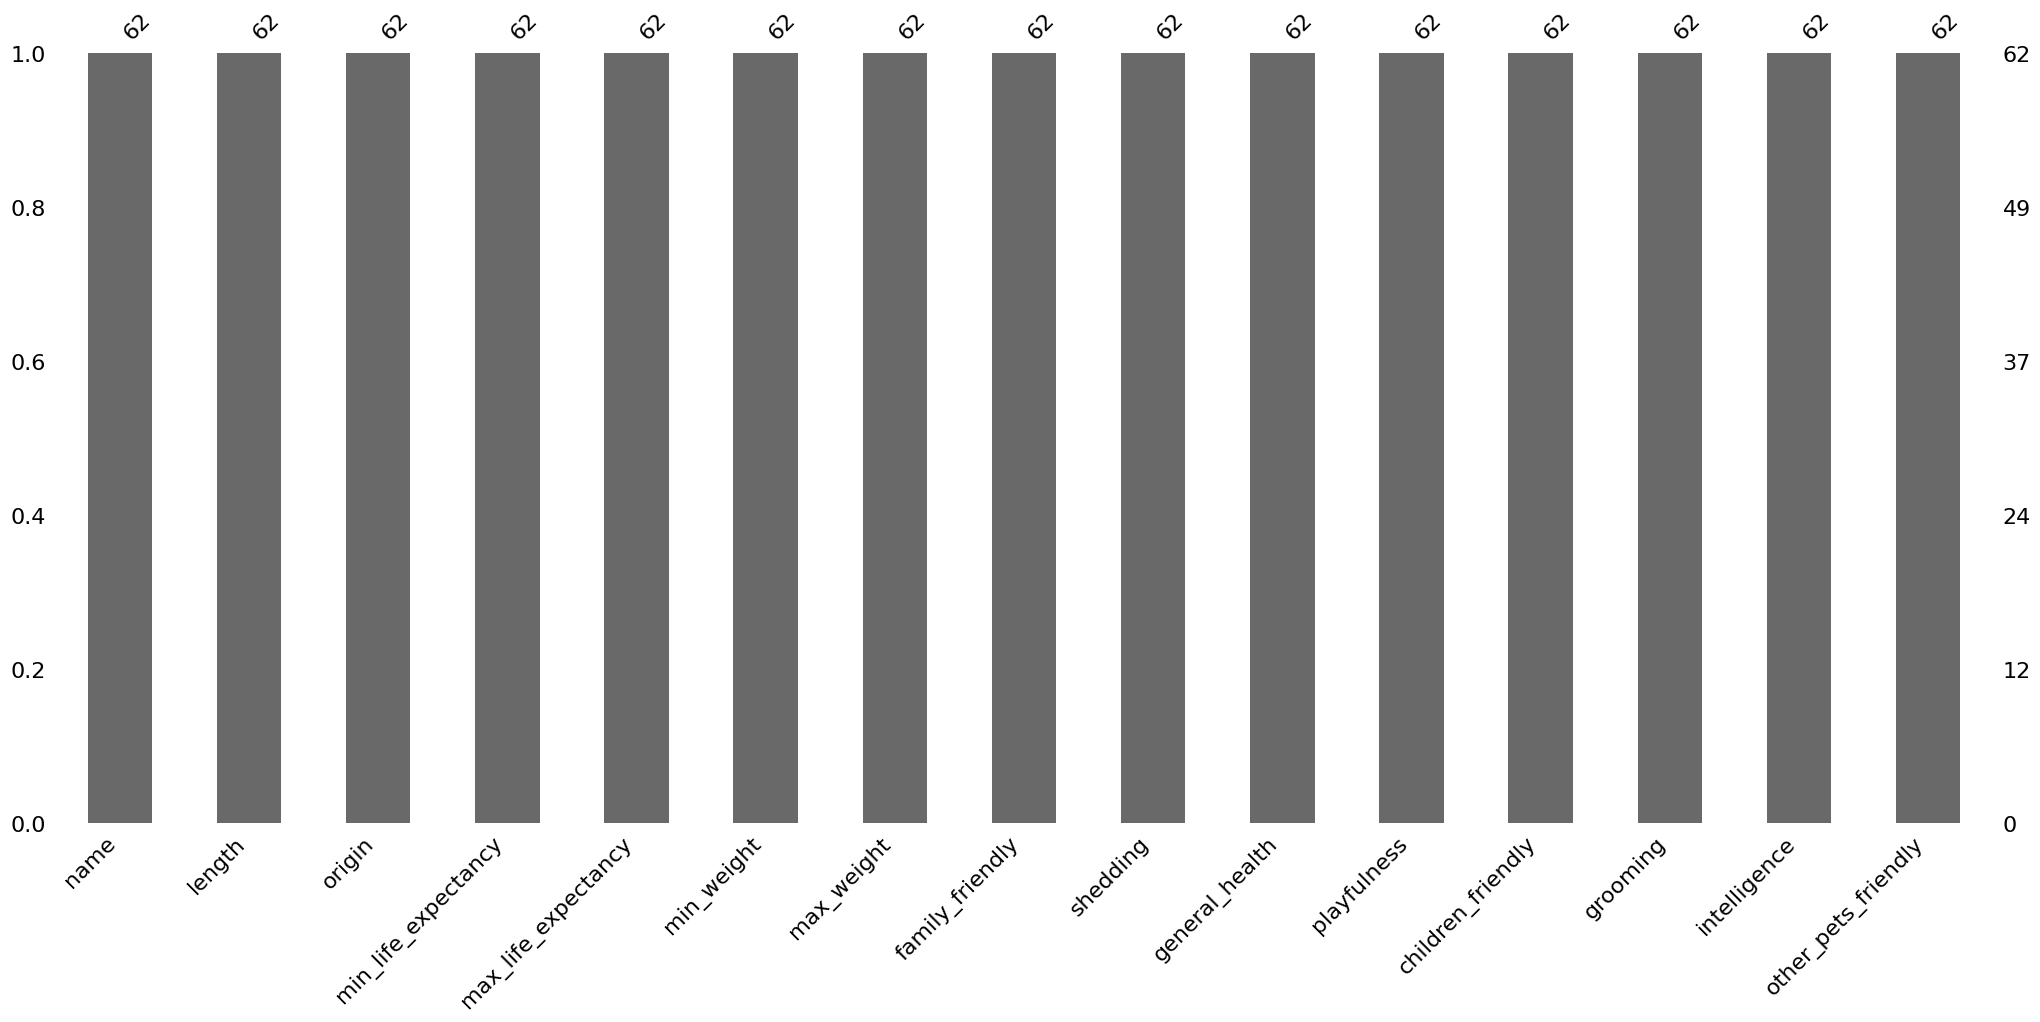

In [5]:
msno.bar(df)
plt.show()

In [6]:
value_counts = df['origin'].value_counts(sort=False)
value_counts

Southeast Asia                   2
Greece                           1
United States and Canada         2
United States                   13
Cyprus                           2
Saudi Arabia                     1
Great Britain                    3
Australia                        1
USA                              3
Unknown                          1
Kentucky, USA                    1
Brazil                           1
Burma and Thailand               1
England                          2
Egypt                            1
United Kingdom                   1
Devon, England                   1
Russia                           4
Italy                            1
Quebec, Canada                   1
Germany                          1
China and Japan                  1
Thailand                         2
Kuril Islands                    1
Maine, USA                       1
Isle of Man, UK                  1
Persia (known as Iran today)     1
Washington, USA                  1
Riverside, Californi

### The  lengths of the cats are not uniform and thus may provide some confusion to users. Therefore, I have decided to normalize the values by categorizing the different types of lenghts using Regex. The range from 10 to 15 is 'small', 15 to 18 is 'small to medium', 18 to 21 is medium to 'large', and finally 21+ is 'large.' Also, all descriptions that have been written as 'long' have been translated to 'large' and all 'short' designations have been converted to 'small.'

In [7]:
df['length'] = df['length'].str.replace(r'(\b1[01] to 12\b|\b11 to 14\b|\b13 to 15\b) inches', 'Small', regex=True)
df['length'] = df['length'].str.replace(r'(\b12 to 16\b|\b12 to 15\b|\b14 to 16\b|\b14 to 18\b|\b14 to 17\b|\b15 to 18\b) inches', 'Small to medium', regex=True)
df['length'] = df['length'].str.replace(r'(\b17 to 22\b|\b13 to 20\b|\b15 to 20\b|\b17 to 21\b|\b13 to 20\b|\b17 to 25\b) inches', 'Medium', regex=True)
df['length'] = df['length'].str.replace(r'(\b22 to 25\b|\b20 to 24\b) inches', 'Medium to large', regex=True)
df['length'] = df['length'].str.replace(r'(\b30 to 40\b) inches', 'Medium to large', regex=True)
df['length'] = df['length'].str.lower()

In [8]:
df['length'] = df['length'].replace({'short': 'small', 'medium, not including tail': 'medium',
                                    'medium to long':'medium to large', 'medium to large, not including tail' : 
                                    'medium to large', 'short to medium' : 'small to medium', 'small to medium, not including tail' :
                                    'small to medium'})

In [9]:
df['length'] = df['length'].str.capitalize()
value_counts = df['length'].value_counts(sort=False)
value_counts

Small to medium    15
Medium             26
Medium to large    11
Large               3
Small               7
Name: length, dtype: int64

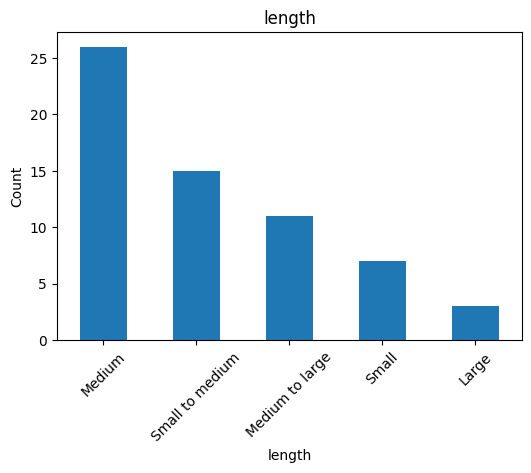

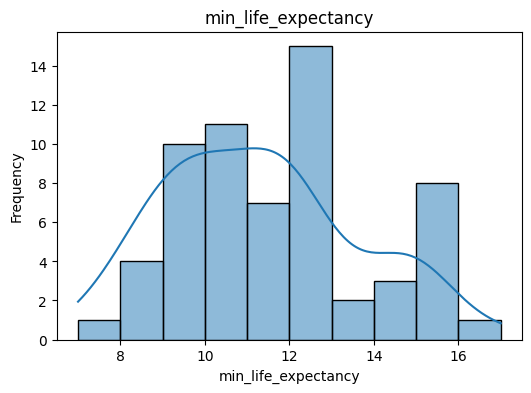

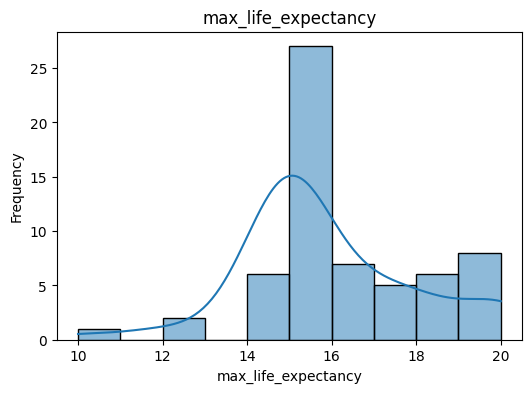

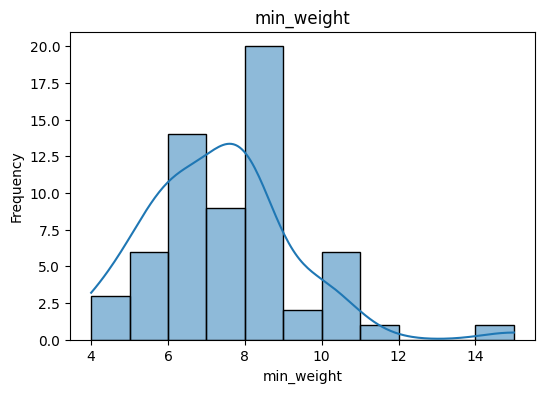

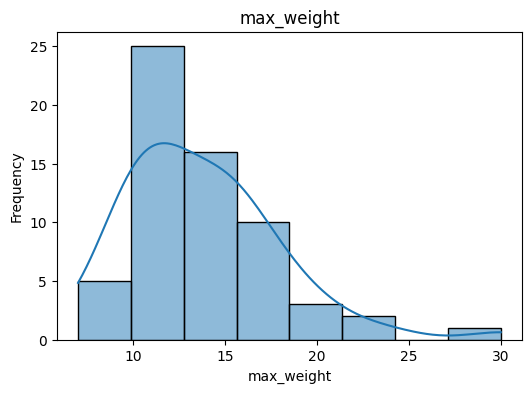

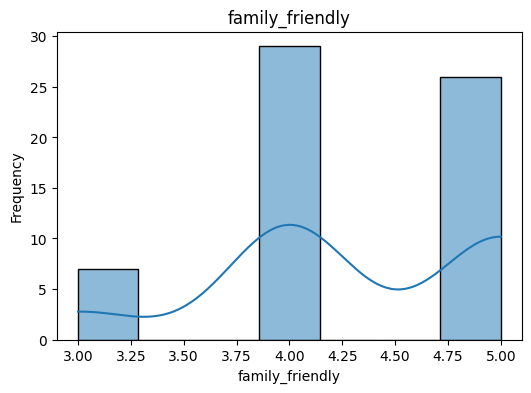

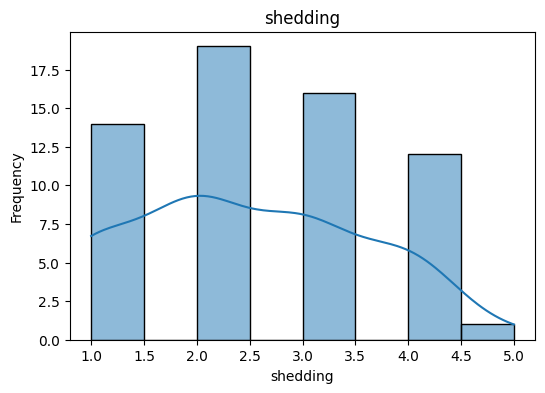

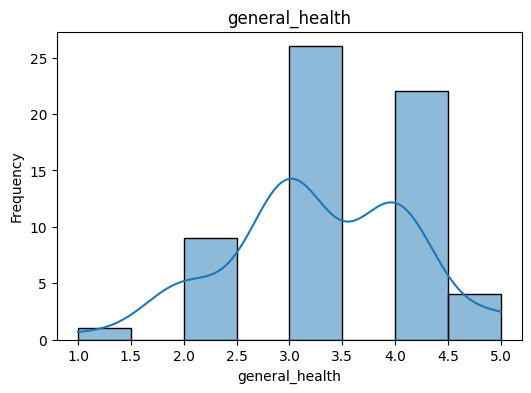

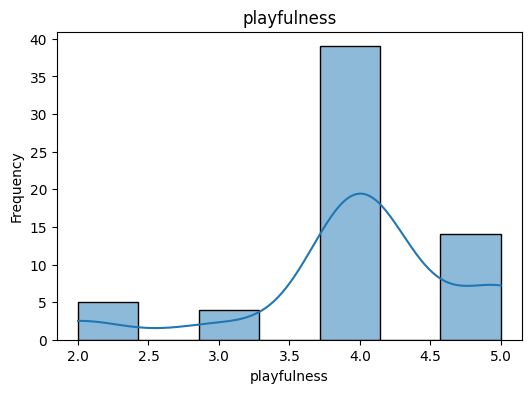

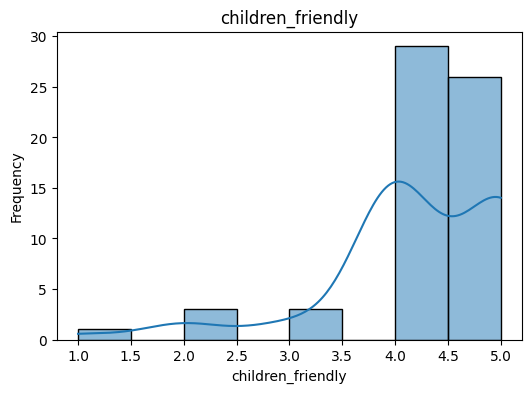

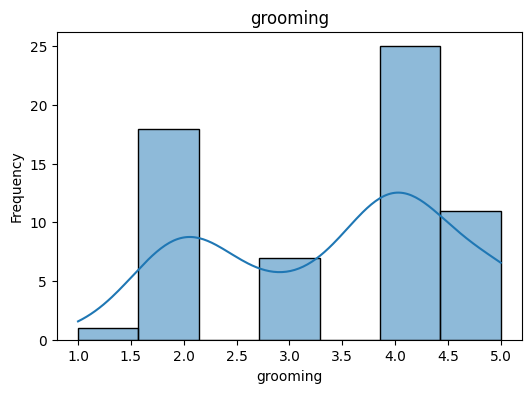

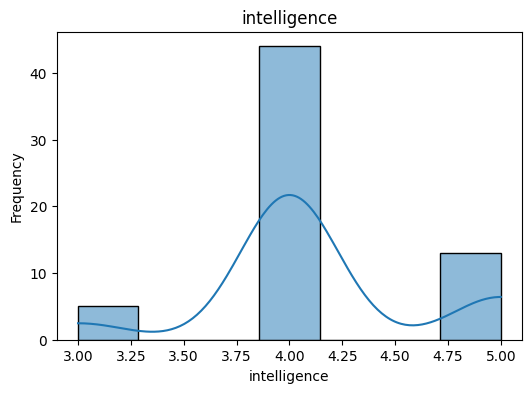

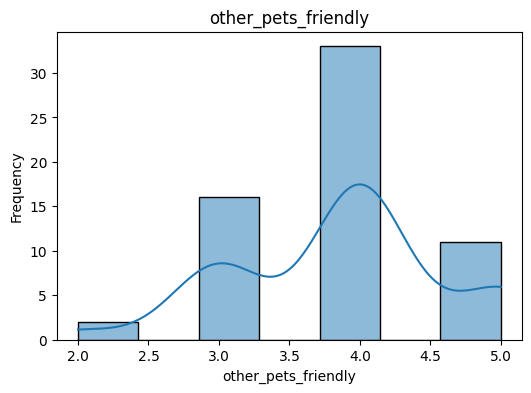

In [10]:
skip = 'origin'
cols = df.columns[df.columns.get_loc('name') + 1:]
cols = [col for col in cols if col != skip]

for column in cols:
    if df[column].dtype in ['float64', 'int64']:  # Numerical columns
        plt.figure(figsize=(6, 4))
        sns.histplot(data=df, x=column, kde=True)
        plt.title(column)
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
    elif df[column].dtype == 'object':  # Categorical columns
        plt.figure(figsize=(6, 4))
        df[column].value_counts().plot(kind='bar')
        plt.title(column)
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

## Running dashboard below

In [11]:
app = dash.Dash(__name__)

characteristic_columns = [col for col in df.columns if col not in ['name', 'origin','length']]

app.layout = html.Div([
    html.H1("Cat Characteristics Dashboard"),
    
    dcc.Dropdown(
        id = 'breed-dropdown',
        options = [{'label': name, 'value': name} for name in df['name'].unique()],
        value = df['name'].iloc[0]  
    ),
    
    html.Div(id='characteristics'),
    
    html.Div(id='comparison'),
    
    dcc.Checklist(
        id='checklist',
        options=[{'label': name, 'value': name} for name in df['name'].unique()],
        value=[]
    ),
    
    dcc.Graph(id='comparison-chart'), 
    
])

@app.callback(
    Output('characteristics', 'children'),
    Output('comparison', 'children'),
    Input('breed-dropdown', 'value')
)

def update_display(selected_breed):
    breed_data = df[df['name'] == selected_breed]
    
    characteristics = html.Div([
        html.H2(f"Characteristics of {selected_breed}"),
        html.P(f"Origin: {breed_data['origin'].iloc[0]} "),
        html.P(f"Length: {breed_data['length'].iloc[0]}"),
        html.P(f"Minimum Life Expectancy: {breed_data['min_life_expectancy'].iloc[0]} Years"),
        html.P(f"Maximum Life Expectancy: {breed_data['max_life_expectancy'].iloc[0]} Years"),
        html.P(f"Minimum Weight: {breed_data['min_weight'].iloc[0]} lbs"),
        html.P(f"Maximum Weight: {breed_data['max_weight'].iloc[0]} lbs"),
        html.P(f"Family Friendliness: {breed_data['family_friendly'].iloc[0]}, Rated out of 5"),
        html.P(f"Amount of Shedding: {breed_data['shedding'].iloc[0]}, Rated out of 5"),
        html.P(f"General Health: {breed_data['general_health'].iloc[0]}, Rated out of 5"),
        html.P(f"Playfulness: {breed_data['playfulness'].iloc[0]}, Rated out of 5"),
        html.P(f"Children Friendliness: {breed_data['children_friendly'].iloc[0]}, Rated out of 5"),
        html.P(f"Amount of Grooming Required : {breed_data['grooming'].iloc[0]}, Rated out of 5"),
        html.P(f"Intelligence: {breed_data['intelligence'].iloc[0]}, Rated out of 5"),
        html.P(f"Friendliness with other pets: {breed_data['other_pets_friendly'].iloc[0]}, Rated out of 5"),

    ])
    comparison = html.Div([
        html.H2("Compare with Another Breed"),
        dcc.Dropdown(
            id='compare-dropdown',
            options=[{'label': name, 'value': name} for name in df['name'].unique()],
            value=df['name'].iloc[1]  # Default value
        ),
        html.Div(id='comparison-results')
    ])
    
    return characteristics, comparison


@app.callback(
    Output('comparison-chart', 'figure'),
    Input('checklist', 'value')
)
def updateComparison(selected_breeds):
    comparison_data = df[df['name'].isin(selected_breeds)]
    
    fig = go.Figure()
    for col in characteristic_columns:
        for breed in selected_breeds:
            breed_data = comparison_data[comparison_data['name'] == breed]
            fig.add_trace(go.Bar(
                x=[breed],  
                y=[breed_data[col].values[0]],  
                name=f'{breed} - {col}'
            ))
    
    fig.update_layout(
        title='Comparison of Cat Characteristics',
        xaxis_title='Cat Breeds',
        yaxis_title='Value Counts',
        barmode='group',  
    )
    
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)
